# Predicting churn
#### Works on Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os 
try:
  os.chdir('drive/My Drive/Colab Notebooks/sony')
  print('Changed directory')
  print(os.getcwd())
except:
  print('Cannot change directory')
  print(os.getcwd())

Mounted at /content/drive
Changed directory
/content/drive/My Drive/Colab Notebooks/sony


## Extra dependencies apart from already installed on Colab

In [2]:
!pip install pandas-profiling==1.4.1 pandas==0.25.3 

# Major imports

In [3]:
import os, re, time
from collections import Counter
from os.path import join as joinpath
# from tqdm import tqdm
# tqdm.pandas()

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from bs4 import BeautifulSoup
import pandas as pd

import numpy as np
np.random.seed(0)
random_state = seed = 0

from pandas_profiling import ProfileReport
from IPython.display import IFrame
from IPython.display import HTML

import matplotlib
%matplotlib inline
import io
import plotly.offline as py #visualization
import plotly.graph_objects as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

pd.options.display.max_rows = 1000

import warnings
warnings.filterwarnings("ignore")

os.getcwd()

'/content/drive/My Drive/Colab Notebooks/sony'

# Reading data

In [70]:
df = pd.read_csv('Data Science Challenge.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [71]:
df["churn"] = df["churn"].astype(int)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [72]:
df.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [73]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


# EDA

In [74]:
profile = ProfileReport(df)
profile.to_file("pandas_profiling.html")
HTML(filename="pandas_profiling.html")

Number of variables,21
Number of observations,3333
Total Missing (%),0.0%
Total size in memory,546.9 KiB
Average record size in memory,168.0 B
Numeric,12
Categorical,3
Boolean,1
Date,0
Text (Unique),1
Rejected,4


## Observations from pandas profiling info
**total day charge** is highly correlated with total day minutes (ρ = 1) <br>
**total eve charge** is highly correlated with total eve minutes (ρ = 1)  <br>
**total night charge** is highly correlated with total night minutes (ρ = 1) <br>
**total intl charge** is highly correlated with total intl minutes

## Dropping correlated columns 

In [75]:
drop_cols = ['total day charge', 'total eve charge', 'total night charge', 'total intl charge']
df.drop(drop_cols, axis=1, inplace=True)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,OH,107,415,371-7191,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,NJ,137,415,358-1921,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,OH,84,408,375-9999,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,OK,75,415,330-6626,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


In [76]:
print("Null values:", df.isnull().sum().values.sum())
print("Unique values :  \n",df.nunique())

Null values: 0
Unique values :  
 state                       51
account length             212
area code                    3
phone number              3333
international plan           2
voice mail plan              2
number vmail messages       46
total day minutes         1667
total day calls            119
total eve minutes         1611
total eve calls            123
total night minutes       1591
total night calls          120
total intl minutes         162
total intl calls            21
customer service calls      10
churn                        2
dtype: int64


In [77]:
# Converting account length to months with max value of 12
def convert_length(x):
  return min(int(np.ceil(x/30)), 12)

df["account length"] = df["account length"].apply(lambda x: min(int(np.ceil(x/30)), 12))

# Setting columns

In [78]:
churn     = df[df["churn"] == True]
not_churn = df[df["churn"] == False]

Id_col     = ['phone number']
target_col = ["churn"]
cat_cols   = ['state', 'area code', 'international plan', 'voice mail plan']
bin_cols   = ["international plan", "voice mail plan"] + target_col
num_cols   = ['number vmail messages',
              'total day minutes',
              'total day calls',
              'total eve minutes',
              'total eve calls',
              'total night minutes',
              'total night calls',
              'total intl minutes',
              'total intl calls',
              'customer service calls', 
              'account length'
              ]        

# Plotting 

In [79]:
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)


#function  for histogram for customer attrition types
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)

#for all categorical columns plot pie
for i in cat_cols :
    plot_pie(i)

#for all categorical columns plot histogram    
for i in num_cols :
    histogram(i)

# Insights from EDA  <br>
## Variable  - Insight  <br>
**total day minutes** - churned customers are talking more in day time <br>
**customer service calls** - churned customers are making more customer support calls<br>
**total eve minutes** - there is a slightly higher evening usage in churned customers <br>
**international plan** - high churn is seen in those who have taken the plan <br>
**voice mail plan** - less churn is seen in those who have taken the plan <br>
**state,account length, area code** - no difference in distribution of users <br>


## Getting data ready

In [15]:
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    df[i] = le.fit_transform(df[i])
    
#Duplicating columns for multi value columns
df = pd.get_dummies(data = df,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_og = df.copy()
df = df.drop(columns=num_cols, axis=1)
df = df.merge(scaled, left_index=True, right_index=True, how="left")

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, \
                            roc_auc_score,roc_curve,scorer, f1_score, precision_score,recall_score
import statsmodels.api as sm
from sklearn.utils import class_weight
from yellowbrick.classifier import DiscriminationThreshold
import plotly.figure_factory as ff

def get_class_weights(y, one_hot=False):
    """Returns a dict of class weights for label encoded as well as one-hot encoded y."""
    if one_hot:
        y = np.argmax(y, axis=1)
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return dict(enumerate(class_weights))

class_weights = get_class_weights(df[target_col[0]])

cols    = [i for i in df.columns if i not in Id_col + target_col]

train_X, test_X, train_Y, test_Y = train_test_split(df[cols], df[target_col], test_size=0.20, stratify=df['churn'], random_state = random_state)

In [53]:
def churn_prediction(algorithm,
                    training_x, testing_x,
                    training_y, testing_y,
                    cols,
                    cf,
                    threshold_plot,
                    fit=True):
    
    #model
    if fit:
      algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    conf_matrix = np.around(conf_matrix * 100 / conf_matrix.sum(axis=1)[:, np.newaxis], 2)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale=False, colorscale="Picnic",
                        name = "matrix")
    
    # fig11 = ff.create_annotated_heatmap(z = conf_matrix ,
    #                     x = ["Not churn","Churn"],
    #                     y = ["Not churn","Churn"],
    #                     showscale=False, colorscale="Picnic",
    #                     name = "matrix")
    
    # fig11.show()
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

# Logistic regression with class weights

LogisticRegression(C=1.0,
                   class_weight={0: 0.5847368421052631, 1: 3.450310559006211},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='ovr', n_jobs=-1,
                   penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.94      0.78      0.85       570
           1       0.36      0.72      0.48        97

    accuracy                           0.77       667
   macro avg       0.65      0.75      0.66       667
weighted avg       0.86      0.77      0.80       667

Accuracy   Score :  0.7691154422788605
Area under curve :  0.7494212334961114 



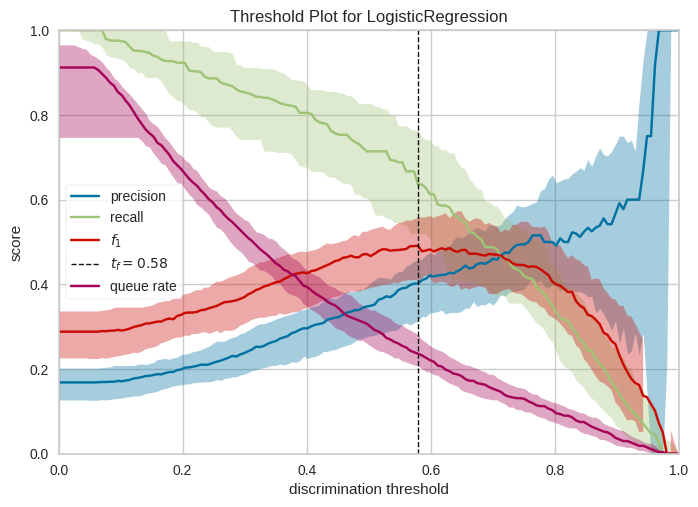

In [18]:
logistic_reg  = LogisticRegression(C=1.0, class_weight=class_weights, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=random_state, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

churn_prediction(logistic_reg,
                 train_X,test_X,
                 train_Y,test_Y,
                 cols,"coefficients",threshold_plot = True)

# Logistic with oversampled data to balance classes in training data

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.94      0.76      0.84       570
           1       0.34      0.72      0.46        97

    accuracy                           0.76       667
   macro avg       0.64      0.74      0.65       667
weighted avg       0.85      0.76      0.79       667

Accuracy   Score :  0.7556221889055472
Area under curve :  0.7415264966540062 



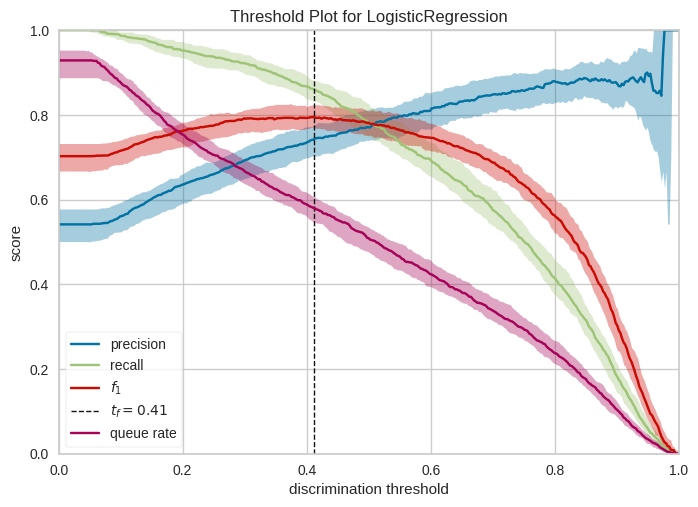

In [19]:
from imblearn.over_sampling import SMOTE

#oversampling minority class using smote
os = SMOTE(random_state = random_state)
smote_X, smote_Y = os.fit_sample(train_X, train_Y)

logistic_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=random_state, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

churn_prediction(logistic_smote,
                  smote_X, test_X,
                  smote_Y, test_Y,
                  cols,"coefficients", threshold_plot = True)


# Top feature selection with chi2

In [20]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#select columns
cols = [i for i in df.columns if i not in Id_col + target_col ]

#dataframe with non negative values
df_x = df_og[cols]
df_y = df_og[target_col]

#fit model with k= 3
select = SelectKBest(score_func = chi2,k = 3)
fit    = select.fit(df_x,df_y)

#Summerize scores
# print ("scores")
# print (fit.scores_)
# print ("P - Values")
# print (fit.pvalues_)

#create dataframe
score = pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_ })
score = score.sort_values(by = "scores" ,ascending =False)


#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols),"Numerical","Categorical")

#plot
trace  = go.Scatter(x = score[score["feature_type"] == "Categorical"]["features"],
                    y = score[score["feature_type"] == "Categorical"]["scores"],
                    name = "Categorial",mode = "lines+markers",
                    marker = dict(color = "red",
                                  line = dict(width =1))
                   )

trace1 = go.Bar(x = score[score["feature_type"] == "Numerical"]["features"],
                y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
                marker = dict(color = "royalblue",
                              line = dict(width =1)),
                xaxis = "x2",yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data=[trace,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

# Decision trees

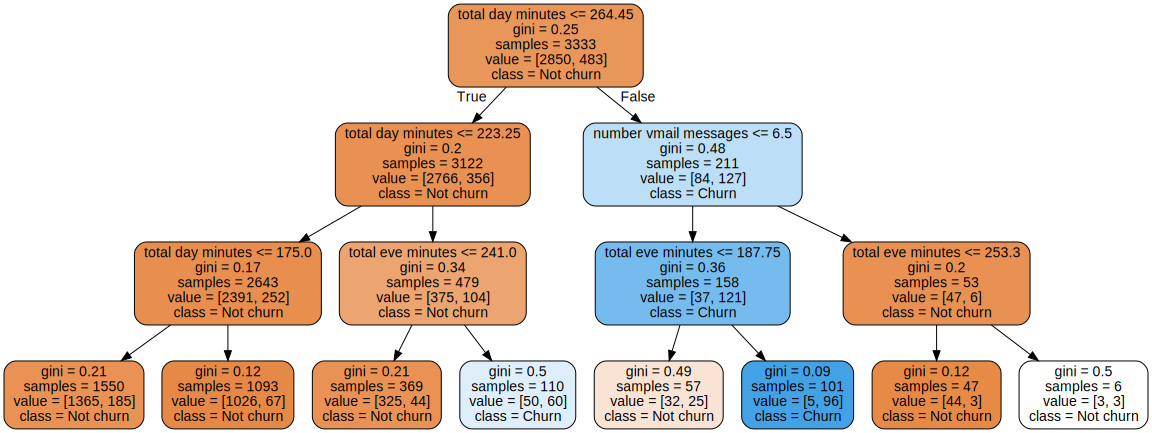

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG,display

#top 3 categorical features
features_cat  = score[score["feature_type"] == "Categorical"]["features"][:3].tolist()

#top 3 numerical features
features_num  = score[score["feature_type"] == "Numerical"]["features"][:3].tolist()


#Function attributes
#columns        - selected columns
#maximum_depth  - depth of tree
#criterion_type - ["gini" or "entropy"]
#split_type     - ["best" or "random"]
#Model Performance - True (gives model output)

def plot_decision_tree(columns,maximum_depth,criterion_type,
                       split_type,model_performance = None) :
    
    #separating dependent and in dependent variables
    dtc_x = df_x[columns]
    dtc_y = df_y[target_col]
    
    #model
    dt_classifier = DecisionTreeClassifier(max_depth = maximum_depth,
                                           splitter  = split_type,
                                           criterion = criterion_type,
                                          )
    dt_classifier.fit(dtc_x,dtc_y)
    
    #plot decision tree
    graph = Source(tree.export_graphviz(dt_classifier,out_file=None,
                                        rounded=True,proportion = False,
                                        feature_names = columns, 
                                        precision  = 2,
                                        class_names=["Not churn","Churn"],
                                        filled = True                         
                                       )
                  )
    
    #model performance
    if model_performance == True :
        telecom_churn_prediction(dt_classifier,
                                 dtc_x,test_X[columns],
                                 dtc_y,test_Y,
                                 columns,"features",threshold_plot = True)
    display(graph)
    
plot_decision_tree(features_num,3,"gini","best")

# xgboost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.9, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=True, subsample=1, verbosity=1)

 Classification report : 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       570
           1       0.94      0.82      0.88        97

    accuracy                           0.97       667
   macro avg       0.96      0.91      0.93       667
weighted avg       0.97      0.97      0.97       667

Accuracy   Score :  0.967016491754123
Area under curve :  0.9079851691083378 



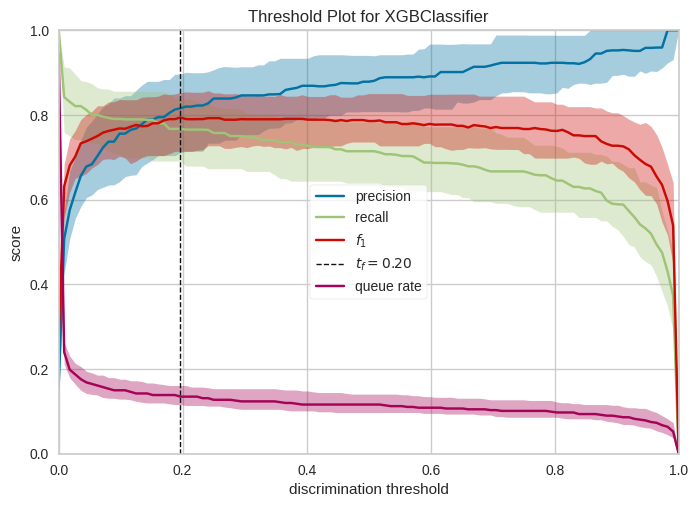

In [22]:
from xgboost import XGBClassifier

xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 10, min_child_weight=1, missing=None, n_estimators=200,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=seed,
                    silent=True, subsample=1)


churn_prediction(xgc,
                train_X,test_X,
                train_Y,test_Y,
                cols,"features",threshold_plot = True)

# xgboost with class weights

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.9, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1,
              sample_weight=array([0.58473684, 3.45031056, 0.58473684, ..., 0.58473684, 0.58473684,
       0.58473684]),
              scale_pos_weight=1, seed=0, silent=True, subsample=1,
              verbosity=1)

 Classification report : 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       570
           1       0.97      0.80      0.88        97

    accuracy                           0.97       667
   macro avg       0.97      0.90      0.93       667
weighted avg       0.97      0.97      0.97       667

Accuracy   Score :  0.9685157421289355
Area

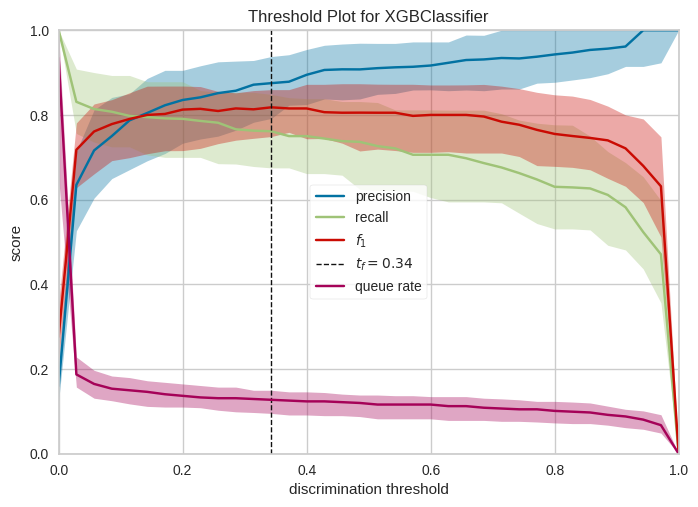

In [23]:
w_array = np.ones(train_Y.shape[0], dtype = 'float')
for i, val in enumerate(train_Y.values.flatten()):
    w_array[i] = class_weights[val]

from xgboost import XGBClassifier

xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=seed,
                    silent=True, subsample=1, sample_weight=w_array)

churn_prediction(xgc,
                train_X,test_X,
                train_Y,test_Y,
                cols,"features",threshold_plot = True)

# LightGBM

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.5, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=500, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report : 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       570
           1       0.93      0.80      0.86        97

    accuracy                           0.96       667
   macro avg       0.95      0.90      0.92       667
weighted avg       0.96      0.96      0.96       667

Accuracy   Score :  0.9625187406296851
Area under curve :  0.8967986977753662 



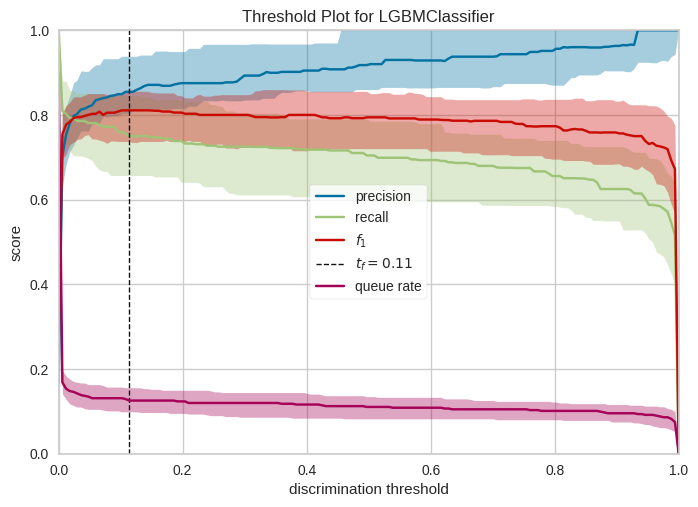

In [24]:
from lightgbm import LGBMClassifier

lgbm_c = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.5, max_depth=7, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)

churn_prediction(lgbm_c,
                  train_X,test_X,
                  train_Y,test_Y,
                  cols,"features",threshold_plot = True)


# All model summary

In [51]:
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

#gives model report in dataframe
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    return pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })

decision_tree = DecisionTreeClassifier(max_depth = 9,
                                       random_state = 123,
                                       splitter  = "best",
                                       criterion = "gini",
                                      )

rfc = RandomForestClassifier(n_estimators = 100,
                             random_state = seed,
                             max_depth = 9,
                             criterion = "gini")

#outputs for every model
model1 = model_report(logistic_reg,train_X,test_X,train_Y,test_Y,
                      "Logistic Regression(Baseline_model)")
model2 = model_report(decision_tree,train_X,test_X,train_Y,test_Y,
                      "Decision Tree")
model3 = model_report(rfc,train_X,test_X,train_Y,test_Y,
                      "Random Forest Classifier")
model4 = model_report(lgbm_c,train_X,test_X,train_Y,test_Y,
                      "LGBM Classifier")
model5 = model_report(xgc,train_X,test_X,train_Y,test_Y,
                      "XGBoost Classifier")

#concat all models
model_performances = pd.concat([model1,model2,model3,
                                model4,model5],
                               axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,3))

py.iplot(table)

In [49]:
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )

trace1  = output_tracer("Accuracy_score","#6699FF")
trace2  = output_tracer('Recall_score',"red")
trace3  = output_tracer('Precision',"#33CC99")
trace4  = output_tracer('f1_score',"lightgrey")
trace5  = output_tracer('Kappa_metric',"#FFCC99")

data = [trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

# H2O AutoML

In [ ]:
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [34]:
import h2o
from h2o.automl import H2OAutoML, get_leaderboard

h2o.init(ip = "localhost")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_s4t3c9j
  JVM stdout: /tmp/tmp_s4t3c9j/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_s4t3c9j/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_unknownUser_t70uww
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [35]:
df.head()

,phone number,international plan,voice mail plan,churn,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,account length
0,382-4657,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.234883,1.566767,0.476643,-0.070610,-0.055940,0.866743,-0.465494,-0.085008,-0.601195,-0.427932,0.846416
1,371-7191,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.307948,-0.333738,1.124503,-0.108080,0.144867,1.058571,0.147825,1.240482,-0.601195,-0.427932,0.105774
2,358-1921,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.591760,1.168304,0.675985,-1.573383,0.496279,-0.756869,0.198935,0.703121,0.211534,-1.188218,0.846416
3,375-9999,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.591760,2.196596,-1.466936,-2.742865,-0.608159,-0.078551,-0.567714,-1.303026,1.024263,0.332354,-0.634867
4,330-6626,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.591760,-0.240090,0.626149,-1.038932,1.098699,-0.276311,1.067803,-0.049184,-0.601195,1.092641,-0.634867


In [36]:
df_train, df_test = train_test_split(df, test_size=0.20, stratify=df['churn'], random_state = random_state)

train = h2o.H2OFrame(df_train)
test = h2o.H2OFrame(df_test)

# Identify predictors and response
x = train.columns
y = "churn"
x.remove(y)

# For classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [38]:
aml = H2OAutoML(max_models=1000, seed=seed, max_runtime_secs=2000)
aml.train(x=x, y=y, training_frame=train)

# AutoML Leaderboard
lb = aml.leaderboard
lb = get_leaderboard(aml, extra_columns='ALL')

# Print all rows (instead of default 10 rows)
lb.head(rows=lb.nrows)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
GBM_grid__1_AutoML_20200719_075452_model_48,0.914344,0.18425,0.850075,0.120212,0.213487,0.0455766,1098,0.036522
GBM_grid__1_AutoML_20200719_075452_model_53,0.914267,0.187181,0.844892,0.114612,0.215937,0.0466287,1923,0.044169
StackedEnsemble_BestOfFamily_AutoML_20200719_075452,0.913417,0.165377,0.85601,0.128142,0.203021,0.0412175,487,0.108415
XGBoost_grid__1_AutoML_20200719_075452_model_57,0.912768,0.195109,0.838,0.13701,0.216869,0.0470323,663,0.016924
XGBoost_grid__1_AutoML_20200719_075452_model_11,0.912768,0.180437,0.851189,0.118876,0.2054,0.0421892,1035,0.01498
XGBoost_grid__1_AutoML_20200719_075452_model_16,0.911906,0.195127,0.833822,0.126531,0.221859,0.0492214,1644,0.017408
GBM_grid__1_AutoML_20200719_075452_model_28,0.911498,0.190892,0.848749,0.141513,0.21907,0.0479917,1358,0.031912
XGBoost_grid__1_AutoML_20200719_075452_model_37,0.910668,0.200594,0.82329,0.144405,0.227241,0.0516385,537,0.014793
XGBoost_grid__1_AutoML_20200719_075452_model_48,0.910229,0.190092,0.840968,0.123858,0.213581,0.0456168,516,0.014371
XGBoost_grid__1_AutoML_20200719_075452_model_65,0.910174,0.189213,0.848169,0.121069,0.205894,0.0423925,1057,0.015626


In [42]:
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20200719_075452_model_48


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,69.0,69.0,25815.0,7.0,7.0,7.0,12.0,41.0,24.971014




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.02076843424553567
RMSE: 0.14411257490425902
LogLoss: 0.09200031931026473
Mean Per-Class Error: 0.04500613580583579
AUC: 0.9921001499863648
AUCPR: 0.9720679374924048
Gini: 0.9842002999727295

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36669726825356497: 


,,0,1,Error,Rate
0,0,2271.0,9.0,0.0039,(9.0/2280.0)
1,1,47.0,339.0,0.1218,(47.0/386.0)
2,Total,2318.0,348.0,0.021,(56.0/2666.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.366697,0.923706,167.0
1,max f2,0.172102,0.916709,215.0
2,max f0point5,0.534282,0.964244,150.0
3,max accuracy,0.447647,0.978995,157.0
4,max precision,0.998505,1.000000,0.0
5,max recall,0.031005,1.000000,335.0
6,max specificity,0.998505,1.000000,0.0
7,max absolute_mcc,0.447647,0.913248,157.0
8,max min_per_class_accuracy,0.135941,0.953947,235.0
9,max mean_per_class_accuracy,0.141145,0.954994,232.0



Gains/Lift Table: Avg response rate: 14.48 %, avg score: 14.41 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010128,0.974766,6.906736,6.906736,1.000000,0.983699,1.000000,0.983699,0.069948,0.069948,590.673575,590.673575,0.069948
1,2,0.020255,0.957354,6.906736,6.906736,1.000000,0.965014,1.000000,0.974356,0.069948,0.139896,590.673575,590.673575,0.139896
2,3,0.030008,0.943144,6.906736,6.906736,1.000000,0.950087,1.000000,0.966469,0.067358,0.207254,590.673575,590.673575,0.207254
3,4,0.040135,0.926929,6.906736,6.906736,1.000000,0.936905,1.000000,0.959009,0.069948,0.277202,590.673575,590.673575,0.277202
4,5,0.050263,0.911195,6.906736,6.906736,1.000000,0.919823,1.000000,0.951113,0.069948,0.347150,590.673575,590.673575,0.347150
5,6,0.100150,0.770699,6.906736,6.906736,1.000000,0.856216,1.000000,0.903842,0.344560,0.691710,590.673575,590.673575,0.691710
6,7,0.150038,0.207991,4.517940,6.112461,0.654135,0.489456,0.885000,0.766059,0.225389,0.917098,351.793993,511.246114,0.896923
7,8,0.200300,0.103443,1.030856,4.837302,0.149254,0.141833,0.700375,0.609418,0.051813,0.968912,3.085608,383.730182,0.898736
8,9,0.300075,0.053083,0.181756,3.289333,0.026316,0.070853,0.476250,0.430345,0.018135,0.987047,-81.824380,228.933290,0.803275
9,10,0.400225,0.034873,0.103472,2.492121,0.014981,0.042884,0.360825,0.333389,0.010363,0.997409,-89.652830,149.212115,0.698287




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.04557660822304977
RMSE: 0.2134867869987503
LogLoss: 0.18424973981853388
Mean Per-Class Error: 0.11598945550404505
AUC: 0.9143441505317699
AUCPR: 0.850075251005182
Gini: 0.8286883010635397

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3452921299697038: 


,,0,1,Error,Rate
0,0,2228.0,52.0,0.0228,(52.0/2280.0)
1,1,84.0,302.0,0.2176,(84.0/386.0)
2,Total,2312.0,354.0,0.051,(136.0/2666.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.345292,0.816216,180.0
1,max f2,0.306249,0.801666,192.0
2,max f0point5,0.499358,0.867742,142.0
3,max accuracy,0.457795,0.949737,150.0
4,max precision,0.995956,1.000000,0.0
5,max recall,0.004619,1.000000,398.0
6,max specificity,0.995956,1.000000,0.0
7,max absolute_mcc,0.363018,0.788885,174.0
8,max min_per_class_accuracy,0.101546,0.857513,276.0
9,max mean_per_class_accuracy,0.275664,0.884011,200.0



Gains/Lift Table: Avg response rate: 14.48 %, avg score: 13.67 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010128,0.963930,6.906736,6.906736,1.000000,0.980484,1.000000,0.980484,0.069948,0.069948,590.673575,590.673575,0.069948
1,2,0.020255,0.928810,6.906736,6.906736,1.000000,0.945998,1.000000,0.963241,0.069948,0.139896,590.673575,590.673575,0.139896
2,3,0.030008,0.899863,6.906736,6.906736,1.000000,0.916803,1.000000,0.948149,0.067358,0.207254,590.673575,590.673575,0.207254
3,4,0.040135,0.870740,6.650931,6.842187,0.962963,0.887256,0.990654,0.932783,0.067358,0.274611,565.093072,584.218682,0.274173
4,5,0.050263,0.833375,6.906736,6.855193,1.000000,0.854527,0.992537,0.917015,0.069948,0.344560,590.673575,585.519295,0.344121
5,6,0.100150,0.578023,6.179711,6.518717,0.894737,0.729335,0.943820,0.823526,0.308290,0.652850,517.971094,551.871689,0.646271
6,7,0.150038,0.258738,3.011960,5.352720,0.436090,0.394584,0.775000,0.680903,0.150259,0.803109,201.195995,435.272021,0.763635
7,8,0.200300,0.136504,0.773142,4.203538,0.111940,0.183794,0.608614,0.556160,0.038860,0.841969,-22.685794,320.353768,0.750302
8,9,0.300075,0.061721,0.259652,2.892196,0.037594,0.091613,0.418750,0.401698,0.025907,0.867876,-74.034828,189.219560,0.663928
9,10,0.400225,0.039717,0.181075,2.213780,0.026217,0.049298,0.320525,0.313516,0.018135,0.886010,-81.892453,121.378034,0.568028




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.9523684,0.010706673,0.93820226,0.9643527,0.9530957,0.945591,0.9606004
1,auc,0.91533613,0.0138983475,0.8938308,0.92886454,0.9261668,0.91220886,0.9156096
2,aucpr,0.8509366,0.02349268,0.82949066,0.8742525,0.8736374,0.85255957,0.824743
3,err,0.047631595,0.010706673,0.061797753,0.03564728,0.046904314,0.054409005,0.039399624
4,err_count,25.4,5.7271285,33.0,19.0,25.0,29.0,21.0
5,f0point5,0.85664517,0.016846279,0.8353222,0.8787879,0.85897434,0.86455333,0.8455882
6,f1,0.8261607,0.023630688,0.80924857,0.85925925,0.8427673,0.80536914,0.8141593
7,f2,0.79824907,0.03522914,0.7847534,0.8405797,0.8271605,0.75376886,0.7849829
8,lift_top_group,7.0574875,1.2013887,5.8681316,7.614286,6.5,6.4216866,8.883333
9,logloss,0.18423326,0.030248659,0.22817425,0.15408841,0.18240844,0.19755325,0.15894195



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-07-19 08:15:05,8 min 7.225 sec,0.0,0.351885,0.413558,0.500000,0.144786,1.000000,0.855214
1,,2020-07-19 08:15:06,8 min 7.308 sec,5.0,0.286498,0.286900,0.932664,0.842948,6.906736,0.059265
2,,2020-07-19 08:15:06,8 min 7.385 sec,10.0,0.245988,0.229165,0.947047,0.880591,6.906736,0.043511
3,,2020-07-19 08:15:06,8 min 7.468 sec,15.0,0.221346,0.196204,0.951430,0.894634,6.906736,0.039385
4,,2020-07-19 08:15:06,8 min 7.545 sec,20.0,0.205958,0.175824,0.955655,0.904531,6.906736,0.034884
5,,2020-07-19 08:15:06,8 min 7.630 sec,25.0,0.194396,0.159740,0.961664,0.914180,6.906736,0.029632
6,,2020-07-19 08:15:06,8 min 7.715 sec,30.0,0.184648,0.145938,0.966638,0.922802,6.906736,0.028507
7,,2020-07-19 08:15:06,8 min 7.792 sec,35.0,0.176863,0.134224,0.973150,0.932873,6.906736,0.027757
8,,2020-07-19 08:15:06,8 min 7.871 sec,40.0,0.170212,0.125544,0.977470,0.941647,6.906736,0.026257
9,,2020-07-19 08:15:06,8 min 7.947 sec,45.0,0.163574,0.116735,0.982489,0.951427,6.906736,0.024381



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,total day minutes,287.048065,1.000000,0.296210
1,customer service calls,127.942207,0.445717,0.132026
2,total eve minutes,121.210503,0.422266,0.125079
3,international plan,111.532585,0.388550,0.115092
4,total intl calls,69.434677,0.241892,0.071651
5,total intl minutes,62.389267,0.217348,0.064381
6,total night minutes,41.073467,0.143089,0.042384
7,number vmail messages,28.174238,0.098152,0.029073
8,total day calls,23.032305,0.080238,0.023767
9,voice mail plan,20.509672,0.071450,0.021164



See the whole table with table.as_data_frame()


# H2O Best Model Metrics: gbm <br>
#### Reported on cross-validation data.   

MSE: 0.04557660822304977 <br>
RMSE: 0.2134867869987503 <br>
LogLoss: 0.18424973981853388 <br>
Mean Per-Class Error: 0.11598945550404505 <br>
**AUC: 0.9143441505317699** <br>
AUCPR: 0.850075251005182 <br>
Gini: 0.8286883010635397 <br>

# Final suggestion 
**Option 1** <br>
H2O's best model GBM <br>
GBM_grid__1_AutoML_20200719_075452_model_48 <br>
**Option 2** <br> 
H2O's xgboost <br>
3 times less latency compared to option 1 <br>
XGBoost_grid__1_AutoML_20200719_075452_model_11 <br>

Note: For latency, see the last column in H2O table

# Interpretability

In [87]:
# !pip install shap 

In [86]:
# import shap

# # print the JS visualization code to the notebook
# shap.initjs()

# # use Kernel SHAP to explain test set predictions
# explainer = shap.LinearExplainer(logistic_reg, train_X, feature_dependence="independent")
# shap_values = explainer.shap_values(test_X)

# # plot the SHAP values for the Setosa output of the first instance
# shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], test_X[0,:], link="logit")